<a href="https://colab.research.google.com/github/javierbaldrich/5509/blob/main/5509.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DTSA 5509 Supervised Learning Project**

This project will be divided into the following parts:

1. Supervised learning problem description
2. EDA procedure
3. Analysis (model building and training)
4. Result
5. Discussion & conclusion

# 1. Supervised learning problem description

For my project I will work on a prediciton problem. Specifically, will use an AdaBoost ensemble classifier to predict loan defaults based on customer information.

I chose this because I work in task automation in the banking industry, and this seemed both tangential to my job and interesting.

The models and the analysis will be based on a this 27.1 MB dataset [1], which "*consists of multiple deteministic factors like borrowe's income, gender, loan pupose etc*".

Detailed information *is not available* for each feature of this dataset. I suspect this is simulated data. Below we import all necessary packages, as well as importing the dataset into a Pandas dataframe and further descriptive information on the dataset.

---


[1] M Yasser H. (2022). "Loan Default Dataset" [Data set]. https://www.kaggle.com/datasets/yasserh/loan-default-dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive 
drive.mount('/content/gdrive')
fraud_df = pd.read_csv('/content/gdrive/MyDrive/5509/loan_default.csv')
f_df_shape = fraud_df.shape


print('This dataset includes', f_df_shape[0], 'samples and', f_df_shape[1] - 1, 'features')
print('This dataset includes the following fields:', [col + ': ' + str(fraud_df[col].dtype) for col in fraud_df.columns])
print('A general overview of the fields in this dataset is provided below')
pd.set_option('display.max_columns', 40)
print(fraud_df.describe(include='all'))

Mounted at /content/gdrive
This dataset includes 148670 samples and 33 features
This dataset includes the following fields: ['ID: int64', 'year: int64', 'loan_limit: object', 'Gender: object', 'approv_in_adv: object', 'loan_type: object', 'loan_purpose: object', 'Credit_Worthiness: object', 'open_credit: object', 'business_or_commercial: object', 'loan_amount: int64', 'rate_of_interest: float64', 'Interest_rate_spread: float64', 'Upfront_charges: float64', 'term: float64', 'Neg_ammortization: object', 'interest_only: object', 'lump_sum_payment: object', 'property_value: float64', 'construction_type: object', 'occupancy_type: object', 'Secured_by: object', 'total_units: object', 'income: float64', 'credit_type: object', 'Credit_Score: int64', 'co-applicant_credit_type: object', 'age: object', 'submission_of_application: object', 'LTV: float64', 'Region: object', 'Security_Type: object', 'Status: int64', 'dtir1: float64']
A general overview of the fields in this dataset is provided below

# 2. EDA procedure

We have the following challenges:
- ID and year fields will not be useful in predicting the respose variable 'Status'.
- Multiple columns have NULL values.
- Multiple columns are categorical and some have of them are ordinal in nature.

Below, we drop several fields 'ID', 'year', 'Gender', 'Interest_rate_spread', 'credit_type', 'co-applicant_credit_type', 'submission_of_application' from the dataset. These are either conceptually unrelated to the behavior of defaulting on debt (e.g. ID), or are problematic to include in some ethical manner, or both (e.g. Gender).

Additionally, we will drop highly correlated fields by getting the correlation matrix, and isolating columns that present a figure >= 0.75.

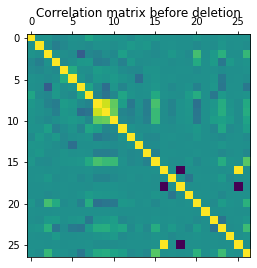

We will drop the following highly correlated features:  ['Interest_rate_spread', 'Secured_by', 'Security_Type']


In [2]:
# Drop fields that are not useful for our analysis
fraud_df.drop(['ID', 'year', 'Gender', 'credit_type', 'co-applicant_credit_type', 'submission_of_application'], axis=1, inplace=True)


# We will test for high correlation and drop features accordingly
# First we quickly remove NAs, the 'Status' response, and we encode the 
# categorical fileds
corr_test_df = fraud_df.copy()
corr_test_df.dropna()
corr_test_df.drop(['Status'], axis=1, inplace=True)
categorical_fields = [col for col in corr_test_df.columns if corr_test_df[col].dtype == 'object']
for col in corr_test_df:
    corr_test_df[col] = LabelEncoder().fit_transform(corr_test_df[col])
# Here we get teh correlation matrix's upper triangle
plt.matshow(corr_test_df.corr())
plt.title("Correlation matrix before deletion")
plt.show()
corr_matrix = corr_test_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# We liest the columns with a correlation >= 0.75
hc_feat = [column for column in upper.columns if any(upper[column] >= 0.75)]
print('We will drop the following highly correlated features: ', hc_feat)
# Drop features 
fraud_df.drop(hc_feat, axis=1, inplace=True)

We now will map the 'age' and 'total units' fields to an ordinal numerical scale. This will allow us to keep additional information about the relative relationship between categories within the field.

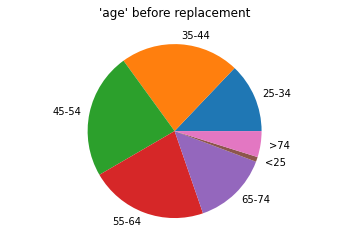

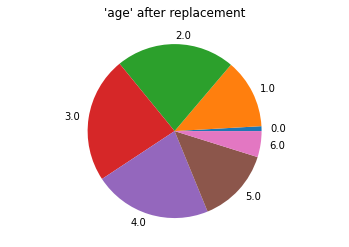

In [3]:
# Example for field 'age' before replacement
pie_counts = fraud_df['age'].groupby(fraud_df['age']).count()
plt.axis('equal')
plt.pie(pie_counts, labels=pie_counts.index)
plt.title("'age' before replacement")
plt.show()
# Replace ordinal categorical with ordinal numerical
age_map = {'<25': 0, '25-34': 1, '35-44': 2, '45-54': 3, '55-64': 4, '65-74': 5, '>74': 6}
total_units_map = {'1U': 0, '2U': 1, '3U': 2, '4U': 3}
fraud_df = fraud_df.replace({"age": age_map})
fraud_df = fraud_df.replace({"total_units": total_units_map})
# Example for field 'age' after replacement
pie_counts = fraud_df['age'].groupby(fraud_df['age']).count()
plt.axis('equal')
plt.pie(pie_counts, labels=pie_counts.index)
plt.title("'age' after replacement")
plt.show()

We will now deal with the missing values by using random forest regression with 200 trees on all features with missing values, using the fields without missing values as predictors.

**This is the first implementation of a supervised model seen in class**. It outputs our 'best' guess' on what the null values actually are, based on the rest of the features.

The result will be a dataframe without null values which we will then keep working on.

Null values before imputation


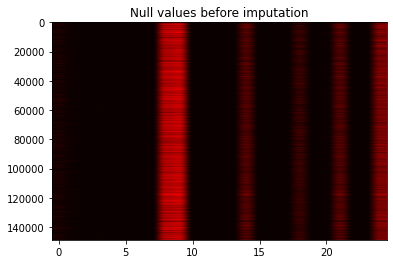

Null values after imputation


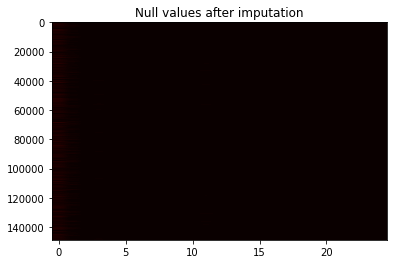

In [4]:
# Encoding all categorical features will allow us to perform a regression on the
# missing values
print('Null values before imputation')
plt.imshow(fraud_df.isnull(), cmap='hot', aspect='auto')
plt.title('Null values before imputation')
plt.show()

# Initial encoding of categorical fields
categorical_fields = [col for col in fraud_df.columns if fraud_df[col].dtype == 'object']
encoded_df = fraud_df.copy()
for col in categorical_fields:
    encoded_df[col] = LabelEncoder().fit_transform(encoded_df[col])

# Individuate all columns with any missing values
non_null_columns = [col for col in encoded_df.columns if encoded_df[col].isnull().sum() == 0]
null_columns = [col for col in encoded_df.columns if encoded_df[col].isnull().sum() > 0]

# Train a random forest regression on the records without missing values
# Predict the values for that field where the original one was null
# Replace the null values in the original dataframe with the predictions
for nul_col in null_columns:
    null_samples = encoded_df[~encoded_df[nul_col].notna()]
    non_null_samples = encoded_df[encoded_df[nul_col].notna()]
    y = non_null_samples.loc[:, nul_col]
    X = non_null_samples.loc[:, non_null_columns]
    clf = RandomForestRegressor(n_estimators=200)
    clf.fit(X, y)
    pred_y = clf.predict(null_samples[non_null_columns])
    fraud_df.loc[null_samples.index, nul_col] = pred_y
  
# Visual on null values
print('Null values after imputation')
plt.imshow(fraud_df.isnull(), cmap='hot', aspect='auto')
plt.title('Null values after imputation')
plt.show()

Now that we have imputed the null values we can proceed to use **logistic encoding on the categorical variables**. This replaces the values of each category within the categorical fields with the log-odds of a positive response within the slice of the dataframe that indeed presents that category. "In essence, the effect of the factor level on the outcome is measured and this effect is used as the numeric encoding." [2]

**This is the second implementation of a supervised model seen in class**.

---

[2] Max Kuhn, Kjell Johnson (2019). "Feature Engineering and Selection: A Practical Approach for Predictive Models". https://bookdown.org/max/FES/categorical-supervised-encoding.html

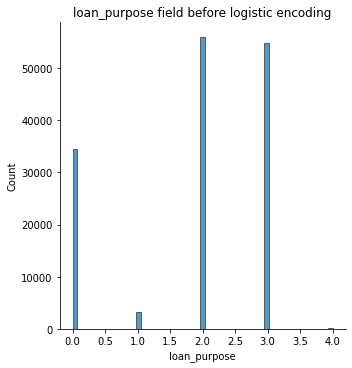

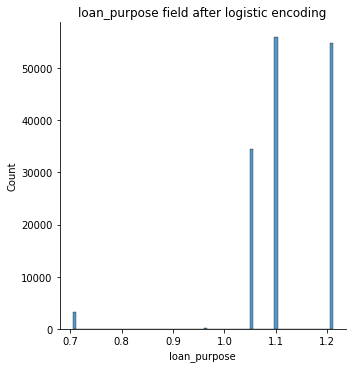

In [5]:
# Encoding all categorical features will allow us to perform a regression on 
# each category within the categorical fields
non_null_df = fraud_df.copy()
for col in categorical_fields:
    non_null_df[col] = LabelEncoder().fit_transform(non_null_df[col])

# Plot loan_purpose field before logistic encoding
loan_purp = sns.displot(non_null_df['loan_purpose'])
plt.title("loan_purpose field before logistic encoding")
plt.show()

for col in categorical_fields:
    effect = {}
    # Iterate over the categories and calculate its effect on loan defaults
    # by running a logistic regression while excluding other categories 
    for category in non_null_df[col].unique():
        try:
            category_slice = non_null_df[non_null_df[col] == category]
            y = category_slice['Status']
            X = category_slice.drop('Status', axis=1, inplace=False)
            unique_res = y.unique()
            if len(unique_res) == 1:
                effect[category] = unique_res[0]
            else:
                clf = LogisticRegression(max_iter=3000).fit(X, y)
                effect[category] = accuracy_score(y, clf.predict(X))
        except Exception as E:
            print(E)
    
    # For each category we retrieve the log-odds and map them to our null
    for key, value in effect.items():
        effect[key] = np.log(effect[key] / (1 + 1e-10 - effect[key] ))
    non_null_df.loc[:, col] = non_null_df.loc[:, col].map(effect)

# Plot loan_purpose field after logistic encoding
loan_purp = sns.displot(non_null_df['loan_purpose'])
plt.title("loan_purpose field after logistic encoding")
plt.show()

# 3. Analysis (model building and training)

Finally we divide the data into a train set and a test set, and we train an AdaBoost model with 500 trees on the train set.

Additional tweaking to this model will be performed in the **4. Results section. **

In [6]:
X = non_null_df.drop('Status', axis=1, inplace=False)
y = non_null_df['Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
clf = AdaBoostClassifier(n_estimators=500, random_state=42).fit(X_train, y_train)

# 4. Results

Below we can see the accuracy and cross validation for our adaBoost model

The accuracy of our initial model on the the dependent variable is  0.9758861908925809
The area under the ROC curve of our initial model is  0.9606461047685153


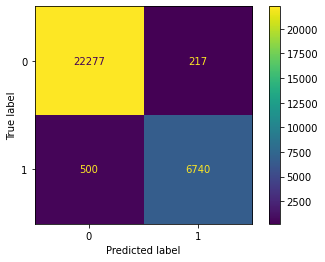

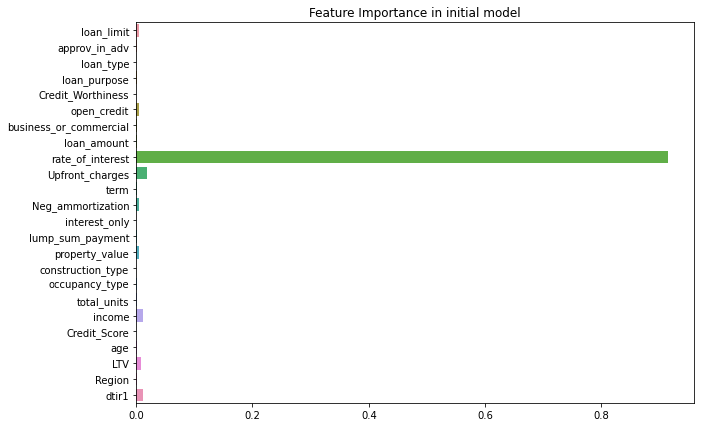

The accuracy of our initial model on the the dependent variable is  0.9775677675388444
The area under the ROC curve of our initial model is  0.9646611349275707


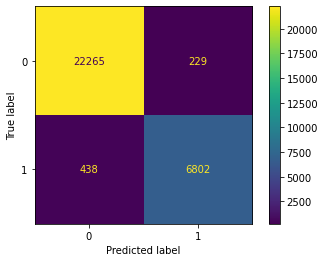

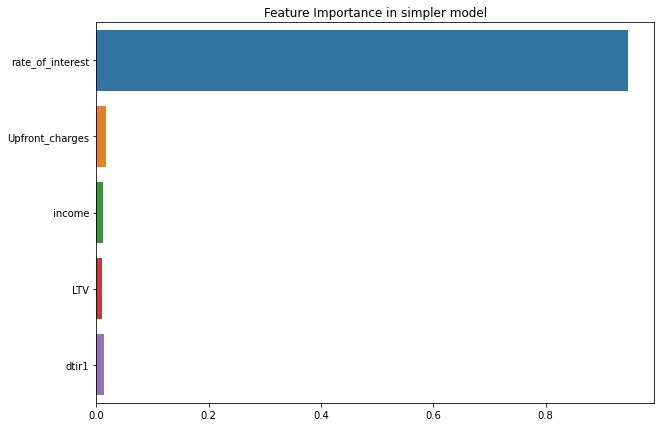

In [7]:
# Print inital results
y_hat = clf.predict(X_test)
print("The accuracy of our initial model on the the dependent variable is ", clf.score(X_test, y_test))
print("The area under the ROC curve of our initial model is ", roc_auc_score(y_test, y_hat))
cm = confusion_matrix(y_test, y_hat, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

# Plot importance of features used in fitting the initial model
plt.figure(figsize=(10, 7))
sns.barplot(y=X_train.columns, x=clf.feature_importances_, )
plt.title("Feature Importance in initial model")
plt.show()
# Get features whose importance in > 0.005
reduced_df = pd.Series(clf.feature_importances_, index=X_train.columns)
reduced_df = reduced_df[reduced_df>0.005]
reduced_columns = reduced_df.index.to_list()

# In accordance with Occam's razor, we fit a simpler model
X = non_null_df[reduced_columns]
y = non_null_df['Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
clf = AdaBoostClassifier(n_estimators=500, random_state=42).fit(X_train, y_train)

# Print new results
y_hat = clf.predict(X_test)
print("The accuracy of our initial model on the the dependent variable is ", clf.score(X_test, y_test))
print("The area under the ROC curve of our initial model is ", roc_auc_score(y_test, y_hat))
cm = confusion_matrix(y_test, y_hat, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

# Plot importance of features used in fitting the simpler model
plt.figure(figsize=(10, 7))
sns.barplot(y=X_train.columns, x=clf.feature_importances_, )
plt.title("Feature Importance in simpler model")
plt.show()

Even though the final, simpler model is slightly worse than the original one, its simplicity leads me to adopt it. Fewer features lead to faster processing times, more clear results, and easier and cheaper replication.

Given that outcomes are comparable, the simple model is the one we will end with.

# 5. Discussion & conclusion

I found [another financial dataset out of Belgium](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) which was interesting since it used real-world data. However, in order to comply with European Union regulations, it had been obfuscated to the point where features were not recognizable whatsoever and interpretation was, therefore, limited.

This was an interesting exercise since we had to clean the dataset, a process during which we used models seen in class, and make subjective judgements regarding feature correlation and model simplicity.

The final model uses only 6 features and it yields remarkable accuracy. I suspect this is due to the fact that this is, most likely, simulated data. It seems to me that real-world model would never be able to make such good predictions.